In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from os.path import abspath, join
from glob import glob
import vaex
import sys
from hammer import dm
root_dir = abspath(join('..', '..'))
sys.path.append(root_dir)
data_dir = join(root_dir, 'Data', 'MCMC', 'dm_mock')
from utils import style
from init import init
from tqdm import tqdm
from matplotlib import pyplot as plt
style()

In [2]:
tipe = 'n'
model = 2

ndim, nwalkers = init(model)

def get_data(data):
    chain = np.load(join(data_dir, 'data', tipe, f'chain-{model}-{data}.npy'))

    zfiles = glob(join(data_dir, 'mock', tipe, 'z*.hdf5'))
    zfiles.sort()
    wfiles = glob(join(data_dir, 'mock', tipe, 'w*.hdf5'))
    wfiles.sort()

    zfile = zfiles[data]
    wfile = wfiles[data]
    zdata = vaex.open(zfile)

    zmid = zdata['z'].to_numpy()
    znum = zdata['num'].to_numpy()
    zerr = zdata['err'].to_numpy()

    wdata = vaex.open(wfile)

    wmid = wdata['w'].to_numpy()
    wnum = wdata['num'].to_numpy()
    werr = wdata['err'].to_numpy()

    zdata = (zmid, znum, zerr)
    wdata = (wmid, wnum, werr)
    return zdata, wdata, chain

In [5]:
def plot_fit(func, axes, zs, ws, zdata, wdata, chain, ndim, n=50000, alpha=0.2, c="C0", label=None):
    zmid, znum, zerr = zdata
    wmid, wnum, werr = wdata
    
    flat_samples = chain.reshape((-1, ndim))
    print(flat_samples.shape)
    fzs = np.empty((n, len(zs)))
    fws = np.empty((n, len(ws)))
    for i in tqdm(range(n)):
        ind = np.random.randint(len(flat_samples))
        theta = flat_samples[ind]
        fzs[i] = func.fz(zs, theta ,1.)
        fws[i] = func.fw(ws, theta ,1.)
    fz_log_mean = np.log(fzs).mean(axis=0)
    fz_log_std = np.log(fzs).std(axis=0)
    fz_mean = np.exp(fz_log_mean)

    fw_log_mean = np.log(fws).mean(axis=0)
    fw_log_std = np.log(fws).std(axis=0)
    fw_mean = np.exp(fw_log_mean)
    maks_z = np.exp(fz_log_mean).max()
    maks_w = np.exp(fw_log_mean).max()
    # axes[0].errorbar(zmid, znum/maks_z, yerr=zerr/maks_z, color=c, alpha=0.3, capsize=2, fmt=".")
    axes[0].fill_between(zs, np.exp(fz_log_mean - 3*fz_log_std)/maks_z, np.exp(fz_log_mean + 3*fz_log_std)/maks_z, alpha=alpha, color=c)
    axes[0].fill_between(zs, np.exp(fz_log_mean - 2*fz_log_std)/maks_z, np.exp(fz_log_mean + 2*fz_log_std)/maks_z, alpha=alpha, color=c)
    axes[0].fill_between(zs, np.exp(fz_log_mean - fz_log_std)/maks_z, np.exp(fz_log_mean + fz_log_std)/maks_z, alpha=alpha, color=c)
    axes[0].plot(zs, fz_mean/maks_z, c=c, ls="--", label=label)
    axes[0].set_ylabel(r'$\nu(z)/\nu_0$')
    axes[0].set_xlabel(r'$z$ [pc]')
    axes[0].set_xlim(zs.min(), zs.max())
    axes[0].set_ylim((np.exp(fz_log_mean - 3*fz_log_std)/maks_z).min(), (np.exp(fz_log_mean + 3*fz_log_std)/maks_z).max()*1.5)
    axes[0].set_yscale('log')
    axes[0].legend()
    
    # axes[1].errorbar(wmid, wnum, yerr=werr, color=c, alpha=0.3, capsize=2, fmt=".")
    axes[1].fill_between(ws, np.exp(fw_log_mean - 3*fw_log_std), np.exp(fw_log_mean + 3*fw_log_std), alpha=alpha, color=c)
    axes[1].fill_between(ws, np.exp(fw_log_mean - 2*fw_log_std), np.exp(fw_log_mean + 2*fw_log_std), alpha=alpha, color=c)
    axes[1].fill_between(ws, np.exp(fw_log_mean - fw_log_std), np.exp(fw_log_mean + fw_log_std), alpha=alpha, color=c)
    axes[1].plot(ws, fw_mean, c=c, ls="--", label=label)
    axes[1].set_ylabel(r'$f_0(w)$')
    axes[1].set_xlabel(r'$w$ [km/s]')
    axes[1].set_xlim(ws.min(), ws.max())
    axes[1].set_ylim(np.exp(fw_log_mean - 3*fw_log_std).min(), np.exp(fw_log_mean + 3*fw_log_std).max()*1.5)
    axes[1].set_yscale('log')
    axes[1].legend()

(680000, 33)


100%|██████████| 50000/50000 [00:41<00:00, 1195.38it/s]


(680000, 33)


100%|██████████| 50000/50000 [00:37<00:00, 1344.88it/s]


(680000, 33)


100%|██████████| 50000/50000 [00:36<00:00, 1357.74it/s]


(680000, 33)


100%|██████████| 50000/50000 [00:38<00:00, 1296.93it/s]


(680000, 33)


100%|██████████| 50000/50000 [00:37<00:00, 1338.30it/s]


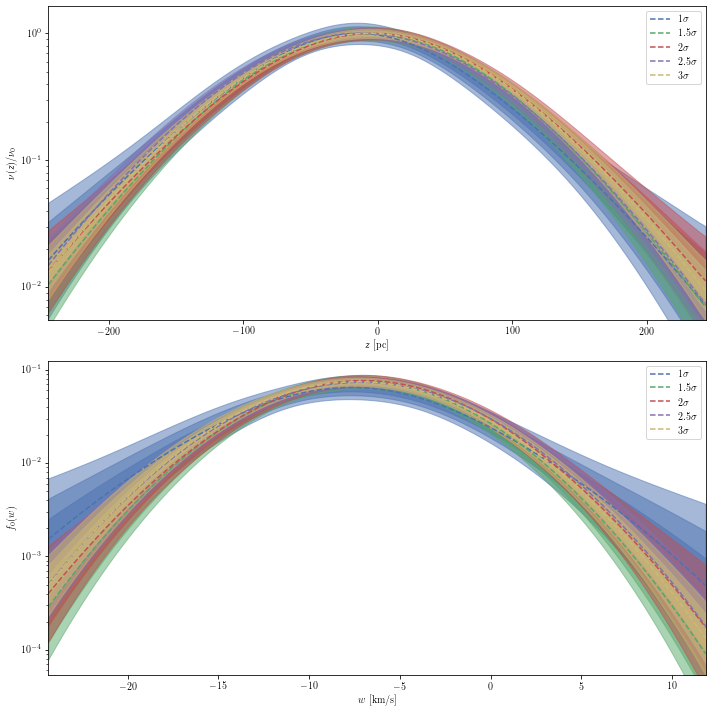

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
zdata, wdata, chain = get_data(4)
zmid = zdata[0]
wmid = wdata[0]
zs = np.linspace(zmid.min()*1.1, zmid.max()*1.1, 100)
ws = np.linspace(wmid.min()*1.1, wmid.max()*1.1, 100)
for i, label in enumerate([1, 1.5, 2, 2.5, 3]):
    zdata, wdata, chain = get_data(i)
    label = r"${}\sigma$".format(label)
    plot_fit(dm, axes, zs, ws, zdata, wdata, chain, ndim, n=50000, label=label, c=f"C{i}", alpha=0.5)
fig.tight_layout()
fig.savefig("fit-mock-f0.pdf", dpi=200)